In [2]:
!pip install catboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [20]:
#import packages

import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt
import seaborn as sea
from lightgbm import LGBMRegressor

In [21]:
def predict__values(model, x_values):
    y_pred = model.predict(x_values)
    return np.expm1(y_pred)

In [22]:
def evaluate_model(models, x, y, split, random_state=42):
  accuracy_scores = []
  x_train_eval, x_valid_eval, y_train_eval, y_valid_eval = train_test_split(x, y, test_size=split, random_state=random_state)
  for model_name, model in models:
    model.fit(x_train_eval, y_train_eval)
    y_pred_eval = model.predict(x_valid_eval)
    rmse = mean_squared_error(y_valid_eval, y_pred_eval, squared=False)
    r_squared = r2_score(y_valid_eval, y_pred_eval)
    rmlse = mean_squared_log_error(y_valid_eval, y_pred_eval, squared=False)
    accuracy_scores.append({
        "model" : model_name,
        "rmlse" : rmlse,
        "rmse" : rmse,
        "r2" : r_squared
    })

  return pd.DataFrame(accuracy_scores)


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
# read input files

train = pd.read_csv('inputs/train.csv', index_col='id')
test = pd.read_csv('inputs/test.csv')

<Axes: >

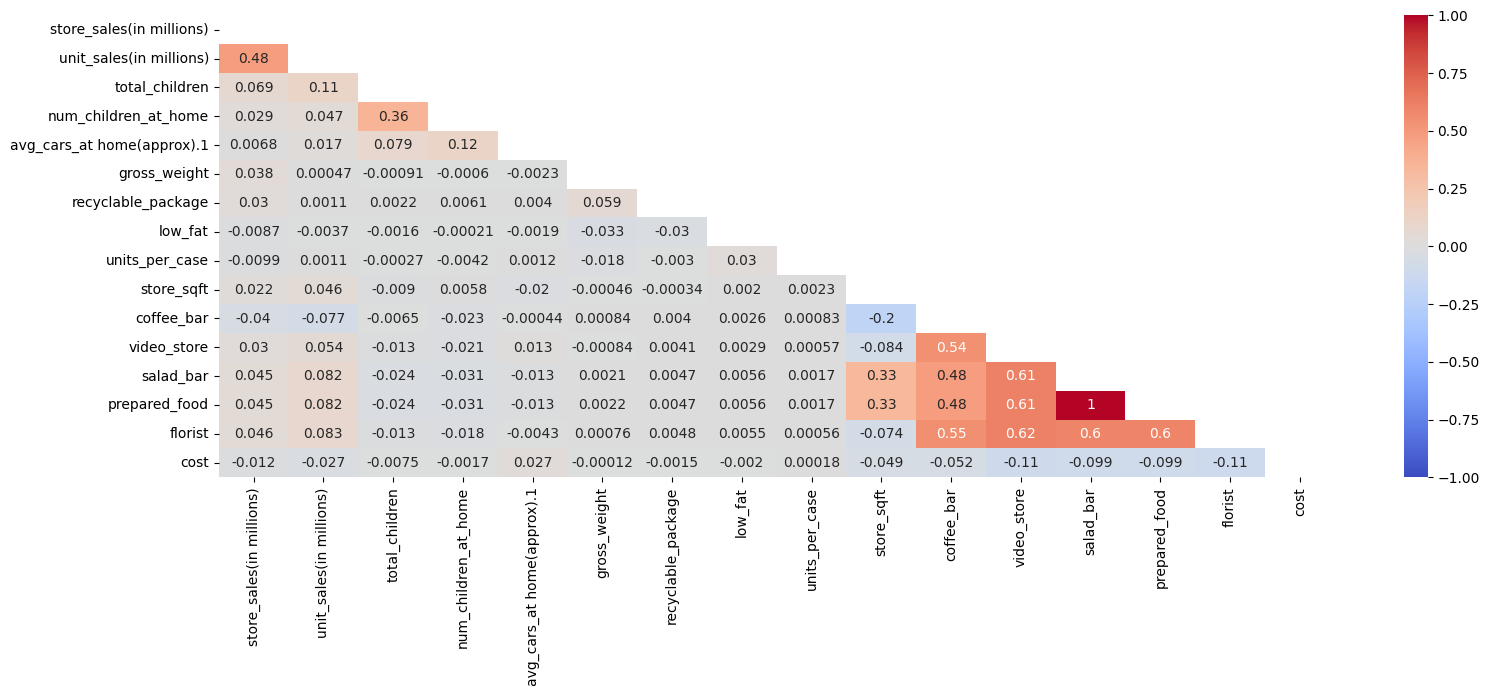

In [26]:
correlation_matrix = train.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(18, 6))
sea.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [27]:
x_train = train.drop(["cost", "prepared_food"], axis=1)
x_test = test.drop(["id", "prepared_food"], axis=1)

y_train = train[["cost"]]

In [28]:
y_train = np.log1p(y_train)

In [29]:
x_train['store_options'] = x_train[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)
x_test['store_options'] = x_test[['coffee_bar', 'video_store', 'salad_bar', 'florist']].sum(axis=1)

In [30]:
x_train["children_ratio"] = x_train["total_children"]/x_train["num_children_at_home"]
x_train["children_ratio"] = x_train["children_ratio"].replace([np.inf, -np.inf], 10)
x_train = x_train.fillna(0)

x_test["children_ratio"] = x_test["total_children"]/x_test["num_children_at_home"]
x_test["children_ratio"] = x_test["children_ratio"].replace([np.inf, -np.inf], 10)
x_test = x_test.fillna(0)

In [31]:
x_train["units_per_sqft"] = x_train["unit_sales(in millions)"]/x_train["store_sqft"]

x_test["units_per_sqft"] = x_test["unit_sales(in millions)"]/x_test["store_sqft"]

In [32]:
x_train.head()

,store_sales(in millions),unit_sales(in millions),total_children,num_children_at_home,avg_cars_at home(approx).1,gross_weight,recyclable_package,low_fat,units_per_case,store_sqft,coffee_bar,video_store,salad_bar,florist,store_options,children_ratio,units_per_sqft
id,,,,,,,,,,,,,,,,,
0,8.61,3.0,2.0,2.0,2.0,10.30,1.0,0.0,32.0,36509.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000082
1,5.00,2.0,4.0,0.0,3.0,6.66,1.0,0.0,1.0,28206.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000071
2,14.08,4.0,0.0,0.0,3.0,21.30,1.0,0.0,26.0,21215.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000189
3,4.02,3.0,5.0,0.0,0.0,14.80,0.0,1.0,36.0,21215.0,1.0,0.0,0.0,0.0,1.0,10.0,0.000141
4,2.13,3.0,5.0,0.0,3.0,17.00,1.0,1.0,20.0,27694.0,1.0,1.0,1.0,1.0,4.0,10.0,0.000108


In [33]:
lgbm_regressor = LGBMRegressor(
    categorical_feature=3,
    learning_rate=0.1,
    min_child_samples=1,
    min_child_weight=10.0,
    n_estimators=450,
    num_leaves=50,
    random_state=1
)

cat_boost_regressor = CatBoostRegressor(
    learning_rate = 0.1,
    l2_leaf_reg = 7,
    iterations = 300,
    depth = 8
)

xgb_regressor = XGBRegressor(
    n_estimators = 300,
    min_child_weight = 3,
    max_depth = 6,
    learning_rate = 0.1,
    gamma = 0.1
)

rf_regressor = RandomForestRegressor(
    n_estimators = 200,
    min_samples_split = 10,
    min_samples_leaf = 4,
    max_depth = 20,
    random_state = 42
)

estimators = [
    ('lgbm', lgbm_regressor),
    ('cat', cat_boost_regressor),
    ('xgb', xgb_regressor),
    ('rf', rf_regressor)
]

In [ ]:
stacked_model = StackingRegressor(
    estimators=estimators
)

stacked_model.fit(x_train, y_train['cost'])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 695
[LightGBM] [Info] Number of data points in the train set: 360336, number of used features: 17
[LightGBM] [Info] Start training from score 4.563348
0:	learn: 0.3148396	total: 97.7ms	remaining: 29.2s
1:	learn: 0.3133068	total: 144ms	remaining: 21.5s
2:	learn: 0.3120241	total: 187ms	remaining: 18.5s
3:	learn: 0.3109103	total: 233ms	remaining: 17.2s
4:	learn: 0.3100608	total: 279ms	remaining: 16.5s
5:	learn: 0.3092677	total: 365ms	remaining: 17.9s
6:	learn: 0.3086220	total: 466ms	remaining: 19.5s
7:	learn: 0.3080829	total: 560ms	remaining: 20.4s
8:	learn: 0.3076804	total: 662ms	remaining: 21.4s
9:	learn: 0.3072759	total: 764ms	remaining: 22.1s
10:	learn:

In [ ]:
y_pred = predict__values(stacked_model, x_test)
final_df = pd.DataFrame( y_pred, columns=['cost'])
final_df.insert(0, 'id', test['id'])
final_df.shape

In [ ]:
final_df.to_csv('outputs/UOM_190215X_stacking.csv', index=False)